## Detecting Adverse Drug Reactions Using GPT-4o

This notebook provides a  guide for detecting adverse drug reactions (ADRs) using a pre-trained GPT-4o model courtesy of Tom Hastain. Compared to our other LLM notebook, this one leverages GPT-4o's advanced language understanding capabilities for sequence classification. 

To point out some of the key differences between the two notebooks, this one:

* Does not have any data preprocessing or initial training steps, as those have already been performed on the model.
* Introduces a prompt, role, and examples to "train", or remind as we like to think of it, the model on what patient narratives classify as severe (1) or not severe (0).
* Breaking up the validation set and running each chunk separately to ensure there are no issues in accessing the model or in billing.

Though more simple in terms of what is required to run, this significantly more robust model secured a Kaggle accuracy score of **0.94338**. The custom prompt, role, and examples play a vital role in this success. We went through several iterations of the wording, code structure, and amount of description and examples. What you see below is the structure and content that provided us with that best score.

Enjoy!

#### NOTE: When label is equal to 1, the reaction is severe. When it is 0, the reaction is not severe.

#### Implementing ChatGPT

In [1]:
# STEP 1: Install and import
#!pip install --quiet openai
import openai
import time
from tqdm import tqdm
import pandas as pd

In [2]:
openai.__version__

'1.78.0'

In [22]:
# OpenAI setup
openai.api_key = # Your API Key Here

# Few-shot examples
few_shot_examples = [
    {"text": "Very hard injection to take, especially on legs even with using ice beforehand. Short-term memory seems to be worsening. Localized swelling on injection site. Fatigued for a day or two after injecting. Had psoriasis since childhood. Psychological benefits outweigh adverse effects.", "label": 0},
    {"text": "Humira controlled Crohn's, but induced psoriasis. Psoriasis almost as bad as Crohn's, but manageable.", "label": 0},
    {"text": "Persistent, daily migraines, severe nausea, and ongoing muscle pain. Struggling to keep up with daily activities.", "label": 1},
    {"text": "Mood swings, anger, and relationship issues after starting Depo shot. Significant emotional distress.", "label": 1},
    {"text": "Spotting, dryness during intercourse, reduced sexual drive, but no mood swings like with other birth control methods. Overall positive experience despite side effects.", "label": 0},
    {"text": "Really bad, constant joint pain, difficulty moving, and chronic fatigue. Impacting work and social life.", "label": 1},
    {"text": "Gained 50 lbs within a year, difficult to orgasm, but improved mood and reduced irritability at a lower dose.", "label": 0},
    {"text": "Stabbing abdominal cramps, neuropathy, nausea, and metal taste in mouth after misdiagnosis. Severe ongoing pain.", "label": 1},
    {"text": "Mild headache, slight fatigue, but able to continue daily activities without much trouble.", "label": 0},
    {"text": "Severe chest pain, shortness of breath, and loss of consciousness. Immediate surgery required.", "label": 1},
]

def gpt_classify_severity(narrative, model_name="ft:gpt-4o-2024-08-06:tom::BTjZdz5E"):
    # Build the few-shot prompt dynamically
    examples_str = "\n\n".join(
        f"Example {k+1}:\nNarrative: \"{ex['text']}\"\nLabel: {ex['label']}"
        for k, ex in enumerate(few_shot_examples)
    )
    
    prompt = f"""
{examples_str}\n\n

You are a licensed medical professional analyzing patient-reported experiences, or side-effects, of medications.
Your task is to classify whether their narratives indicate a severe or non severe drug reaction.

Severe (adverse) reactions may also include: physical discomfort, behavioral or psychological side effects, unwanted weight changes, sleep issues, dependency, or sexual dysfunction.

Respond only with 1 (adverse/severe reaction) or 0 (no reaction).

Narrative: "{narrative}"
"""

    try:
        response = openai.chat.completions.create(
            model=model_name,
            messages=[
                {"role": "system", "content": "You are a medical physician classifying Adverse Drug Reaction (ADR) severity from reported symptoms."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=3,
            temperature=0,
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print("OpenAI error:", e)
        return "-1"

In [24]:
gpt_classify_severity("I took tylenol and had a severe reaction.")

'1'

In [26]:
df = pd.read_csv("val_DrugExp.csv")
df1 = df.iloc[0:100]
df2 = df.iloc[100:500]
df3 = df.iloc[500:1000]
df4 = df.iloc[1000:]

In [28]:
tqdm.pandas()

Train each data frame (df1, df2, etc.) once via the cell below. You will have to manually switch between each data frame.

In [42]:
df4["label"] = df4.text.astype(str).progress_apply(lambda x: gpt_classify_severity(x))

100%|██████████| 360/360 [04:19<00:00,  1.39it/s]  
/var/folders/h9/fvt00j_j2_b11vv2gy75080w0000gn/T/ipykernel_72540/4039086501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4["label"] = df4.text.astype(str).progress_apply(lambda x: gpt_classify_severity(x))


Check that the labels were applied before proceeding with the next df:

In [44]:
df4

,text,label
1000,Behcet's Disease fatigue for a week after infu...,0
1001,ADD none totally bummed that no add med i ve t...,1
1002,palmer hyperhydrosis dry mouth slightly blurre...,0
1003,Fibromyalgia none i am taking soma 350 mg in a...,1
1004,"Acne Redness, Dry Flaky skin, Irritation, Burn...",0
...,...,...
1355,Extreme hayfever for over 60 yrs. i have taken...,0
1356,Sudden anxiety attacks since child. Mild tired...,0
1357,Epilepsy it is a good medicine for seizure con...,1
1358,"Anxiety, IBS occasionally blurred vision with ...",0


#### Predict on Kaggle Data

In [46]:
out = pd.concat([df1,df2,df3,df4])
out[['text','label']].to_csv("to_kaggle1.csv", index = False)

In [9]:
df = pd.read_csv("train_DrugExp.csv")
df.head()

,text,label
0,"crohns, severe in duodenum feet and ankles hur...",1
1,Severe back pain-surgery/ sciatica the only si...,0
2,c. diff extreme nausea and stomach upset loss ...,1
3,ADHD long term use of adhd medication from 1st...,1
4,To start menstruation severe cramping bloating...,0


In [10]:
!pip install --user wordcloud

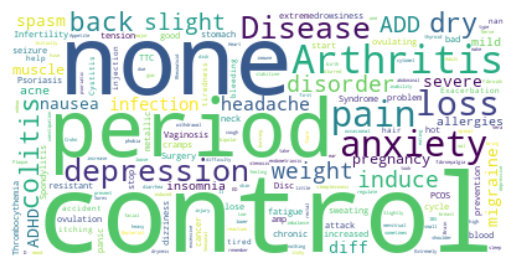

In [11]:
# Mild ADRs:

import matplotlib.pyplot as plt
from wordcloud import WordCloud

temp = df.query('label<0.5')
text = " ".join(text.split()[1] for text in temp.text)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

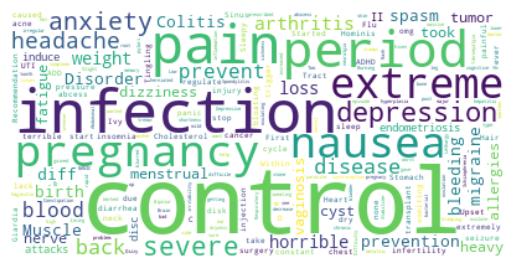

In [12]:
# Severe ADRs:

import matplotlib.pyplot as plt
from wordcloud import WordCloud

temp = df.query('label>0.5')
text = " ".join(text.split()[1] for text in temp.text)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [13]:
!pip install --user spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 72.1 MB/s eta 0:00:00:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 2.2.3 requires scikit-plot, which is not installed.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.4 which is incompatible.
explainerdashboard 0.4.8 requires numpy<2, but you have numpy 2.2.4 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.0 which is incompatible.
pandas-profiling 3.0.0 requires tangled-up-in-unicode==0.1.0, but you have tangled-up-in-unicode 0.2.

In [14]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
import spacy
from spacy import displacy

text = df.text.iloc[0]
nlp = spacy.load("en_core_web_sm")
doc = nlp(text)
displacy.render(doc, style="ent")

In [16]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")

pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple") # pass device=0 if using gpu
pipe("""The patient reported no recurrence of palpitations at follow-up 6 months after the ablation.""")

Device set to use cpu


[{'entity_group': 'Sign_symptom',
  'score': 0.9999311,
  'word': 'pal',
  'start': 38,
  'end': 41},
 {'entity_group': 'Sign_symptom',
  'score': 0.90633154,
  'word': '##pitations',
  'start': 41,
  'end': 50},
 {'entity_group': 'Clinical_event',
  'score': 0.99975544,
  'word': 'follow',
  'start': 54,
  'end': 60},
 {'entity_group': 'Date',
  'score': 0.999867,
  'word': '6 months after',
  'start': 64,
  'end': 78}]

Submit your kaggle csv file through the link on Canvas.